<img src="https://raw.githubusercontent.com/NCAR/dask-tutorial/main/images/NCAR-contemp-logo-blue.png"
     width="750px"
     alt="NCAR logo"
     style="vertical-align:middle;margin:30px 0px"/>

# Dask DataFrame - Parallelized Pandas

**ESDS Dask Tutorial | 06 February, 2023**  

Negin Sobhani, Brian Vanderwende, Deepak Cherian, Ben Kirk  
Computational & Information Systems Lab (CISL)  
[negins@ucar.edu](negins@ucar.edu), [vanderwb@ucar.edu](mailto:vanderwb@ucar.edu)
---------

<img src="https://docs.dask.org/en/stable/_images/dask-dataframe.svg"
     align="right"
     width="50%"
     alt="Dask DataFrame is composed of pandas DataFrames"/>

A pandas dataframe is an annotated tabular representation of a 2D dataset, often with heterogeneous data (multiple data types) across at least one dimension. Dask Dataframes extend pandas dataframes to perform work in parallel and distributed workflows.

A general rule of thumb for pandas is:

> "Have 5 to 10 times as much RAM as the size of your dataset"
>
> ~ Wes McKinney (2017) in [10 things I hate about pandas](https://wesmckinney.com/blog/apache-arrow-pandas-internals/)

Here "size of dataset" means dataset size on _the disk_.

Much like Dask Arrays, Dask Dataframes become useful when the datasets exceed the above rule.

### In this tutorial, you learn:

* ????

**Related Documentation**

* [DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html)
* [DataFrame screencast](https://youtu.be/AT2XtFehFSQ)
* [DataFrame API](https://docs.dask.org/en/latest/dataframe-api.html)
* [DataFrame examples](https://examples.dask.org/dataframe.html)
* [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)

## Set up your local cluster
Create a local Dask cluster and connect it to the client. Don't worry about this bit of code for now, you will learn more in the Distributed notebook.

In [3]:
from dask.distributed import Client

client = Client(n_workers=4)
client

/ncar/usr/jupyterhub.hpc.ucar.edu/jupyterhub-20220511/lib/python3.9/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45589 instead
  warnings.warn(
2023-01-23 13:49:32,539 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/work/negins/dask/dask-worker-space/worker-inqfgbfo', purging
2023-01-23 13:49:32,547 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/work/negins/dask/dask-worker-space/worker-sda77y84', purging
2023-01-23 13:49:32,553 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/work/negins/dask/dask-worker-space/worker-ra4epdtx', purging
2023-01-23 13:49:32,557 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/work/negins/dask/dask-worker-space/worker-hwk142tp', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/45589/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/45589/status,Workers: 4
Total threads: 4,Total memory: 4.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42835,Workers: 4
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/45589/status,Total threads: 4
Started: Just now,Total memory: 4.00 GiB
Comm: tcp://127.0.0.1:46836,Total threads: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/44143/status,Memory: 1.00 GiB
Nanny: tcp://127.0.0.1:40015,


## Load historical job data from 2022 June

In [7]:
import pandas as pd
june_jobs = pd.read_csv('data/jobs-202206.dat')
jj = june_jobs

In [8]:
# Display the top five rows of the dataframe
jj.head()

,Job ID,Queue,Nodes,NCPUs,NGPUs,Req Mem (GB),Used Mem(GB),Job Submit,Job Start,Job End,Walltime (h),Exit Status,Job Name
0,3249133.casper-pbs,htc,1,1,0,10.0,0.0,2022-06-30T23:55:45,2022-06-30T23:57:35,2022-06-30T23:57:46,0.17,0,q_merge_and_scp
1,3249131.casper-pbs,gpgpu,1,1,1,10.0,0.2,2022-06-30T23:55:45,2022-06-30T23:55:47,2022-06-30T23:57:36,1.00,0,q_pipesubmit
2,3248931.casper-pbs,htc,1,2,0,1.0,0.0,2022-06-30T22:50:45,2022-06-30T23:57:07,2022-06-30T23:57:11,1.00,0,RRLXfer
3,3248928.casper-pbs,htc,1,1,0,1.0,0.0,2022-06-30T22:50:40,2022-06-30T22:50:41,2022-06-30T23:57:08,9.00,0,RR_FINN_Listen
4,3249132.casper-pbs,gpgpu,1,1,1,10.0,0.2,2022-06-30T23:55:45,2022-06-30T23:55:47,2022-06-30T23:57:00,1.00,0,q_cat_pipesubmit


#### How many jobs did users run in June?

In [9]:
len(jj)

866000

#### How many jobs ran in each queue?

In [10]:
# Create a "groupby object" based on the selected columns
# which can return info like the count of each type of the column value
jj.groupby('Queue').size()

Queue
R3073777          4
S870294         267
a100              6
asdgpu          104
gpgpu          2307
htc          838269
jhublogin       890
largemem        234
rda           22429
system            1
tdd             780
vis             709
dtype: int64

<AxesSubplot:xlabel='Queue'>

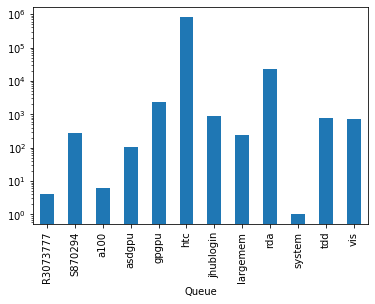

In [11]:
# Here we easily plot the prior data using matplotlib from pandas
jj.groupby('Queue').size().plot.bar(logy = True)

#### Where do Dask jobs run?

In [12]:
# Select only one column of data
jj['Job Name'].head()

0     q_merge_and_scp
1        q_pipesubmit
2             RRLXfer
3      RR_FINN_Listen
4    q_cat_pipesubmit
Name: Job Name, dtype: object

In [13]:
# Get the number of each value in Job Name (similar to size above)
jj['Job Name'].value_counts().head()

job                        429003
mpas_real-time_graphics    185963
dask-worker                 20125
dsrqst                      19650
gfs_real-time_graphics      17280
Name: Job Name, dtype: int64

In [14]:
# Create a new dataframe of job entries with the Job Name "dask-worker"
dj = jj[jj['Job Name'] == 'dask-worker']
dj.groupby('Queue').size()

Queue
htc         20081
largemem        1
tdd            43
dtype: int64

*Is this what we expect? Dask tasks tend to be **bursty, high-throughput** computing.*

#### What are typical worker CPU and memory needs?

In [15]:
# groupby operations can be on multiple columns and ones generated by manipulating a column
dj.groupby(['NCPUs', dj['Req Mem (GB)'] // 10 * 10]).size()

NCPUs  Req Mem (GB)
1      0.0              696
       10.0            2791
       20.0            5865
       30.0             220
       40.0              60
       50.0             886
       60.0              50
       70.0              20
       100.0           5345
       110.0             20
       200.0             61
       220.0            185
       250.0           1310
       320.0            164
       330.0             16
       350.0             16
       420.0              1
2      20.0              12
       250.0            339
4      10.0              12
       40.0             735
5      10.0              25
       100.0             10
6      100.0              1
9      250.0             72
10     100.0              4
12     200.0              1
       300.0            700
18     200.0             34
       300.0              7
24     200.0              4
36     100.0            110
       300.0            353
dtype: int64

#### How much of the request memory is wasted?

In [16]:
# Creating a new column
#dj['Unused Mem'] = dj['Req Mem (GB)'] - dj['Used Mem(GB)']

In [17]:
# Check all datatypes of the dataframe (here we see usedmem did not get interpreted properly)
dj.dtypes

Job ID           object
Queue            object
Nodes             int64
NCPUs             int64
NGPUs             int64
Req Mem (GB)    float64
Used Mem(GB)     object
Job Submit       object
Job Start        object
Job End          object
Walltime (h)    float64
Exit Status       int64
Job Name         object
dtype: object

In [18]:
# Let's cast used mem as the dtype that we want (float)
dj['Used Mem(GB)'] = dj['Used Mem(GB)'].astype(float)

/glade/scratch/negins/ipykernel_162350/1533624428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dj['Used Mem(GB)'] = dj['Used Mem(GB)'].astype(float)


In [19]:
# To avoid the above problem, we need to make sure we copy data in our dask job dataframe, and not reference it
dj = jj[jj['Job Name'] == 'dask-worker'].copy()
dj['Used Mem(GB)'] = dj['Used Mem(GB)'].astype(float)
dj.dtypes

Job ID           object
Queue            object
Nodes             int64
NCPUs             int64
NGPUs             int64
Req Mem (GB)    float64
Used Mem(GB)    float64
Job Submit       object
Job Start        object
Job End          object
Walltime (h)    float64
Exit Status       int64
Job Name         object
dtype: object

In [20]:
dj['Unused Mem (%)'] = (dj['Req Mem (GB)'] - dj['Used Mem(GB)']) / dj['Req Mem (GB)'] * 100.0

<AxesSubplot:xlabel='% Unused', ylabel='Number of Jobs'>

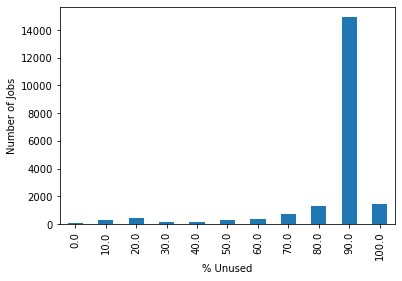

In [21]:
dj.groupby(dj['Unused Mem (%)'] // 10 * 10).size().plot.bar(xlabel = '% Unused', ylabel = 'Number of Jobs')

*Typically on busy systems, wasted resources means less job throughput, meaning...*  

**LONGER WAIT TIMES :-(**

#### How much of the requested walltime do workers actually use?

In [22]:
dj['Job Start'].head()

265    2022-06-30T19:24:15
302    2022-06-30T19:05:16
414    2022-06-30T15:35:51
415    2022-06-30T18:20:35
416    2022-06-30T16:24:40
Name: Job Start, dtype: object

In [23]:
# This could also be done with a list comprehension!
time_cols = ['Job Submit', 'Job Start', 'Job End']

for col in time_cols:
    dj[col] = pd.to_datetime(dj[col])

In [24]:
dj.dtypes

Job ID                    object
Queue                     object
Nodes                      int64
NCPUs                      int64
NGPUs                      int64
Req Mem (GB)             float64
Used Mem(GB)             float64
Job Submit        datetime64[ns]
Job Start         datetime64[ns]
Job End           datetime64[ns]
Walltime (h)             float64
Exit Status                int64
Job Name                  object
Unused Mem (%)           float64
dtype: object

In [25]:
dj['elapsed'] = (dj['Job End'] - dj['Job Start']).dt.total_seconds() / 3600

In [26]:
dj.groupby(dj['Walltime (h)'] // 1).mean()['elapsed']

Walltime (h)
0.0     0.163884
1.0     0.660678
2.0     0.737050
3.0     1.054678
4.0     2.247427
5.0     1.502826
6.0     3.841324
8.0     7.616667
10.0    6.398326
12.0    0.953402
20.0    2.161327
22.0    0.413441
Name: elapsed, dtype: float64

#### How big is the June 2022 dataset?

In [27]:
# Shell commands can be run with "!' in a notebook
!ls -lh data/jobs-202206.dat

fatal: not a git repository (or any parent up to mount point /glade)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
-rw-r--r-- 1 negins ncar 99M Jan 11 12:30 data/jobs-202206.dat


In [28]:
# dataframe method to get metadata
jj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866000 entries, 0 to 865999
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Job ID        866000 non-null  object 
 1   Queue         866000 non-null  object 
 2   Nodes         866000 non-null  int64  
 3   NCPUs         866000 non-null  int64  
 4   NGPUs         866000 non-null  int64  
 5   Req Mem (GB)  866000 non-null  float64
 6   Used Mem(GB)  866000 non-null  object 
 7   Job Submit    866000 non-null  object 
 8   Job Start     866000 non-null  object 
 9   Job End       866000 non-null  object 
 10  Walltime (h)  866000 non-null  float64
 11  Exit Status   866000 non-null  int64  
 12  Job Name      866000 non-null  object 
dtypes: float64(2), int64(4), object(7)
memory usage: 85.9+ MB


In [29]:
import sys

# Define function to display variable size in MiB
def var_size(in_var):
    result = sys.getsizeof(in_var) / 1024 / 1024
    print(f"Size of variable: {result:.2f} MiB")

In [30]:
var_size(jj)

Size of variable: 447.34 MiB


In [31]:
# deep option will include memory used by mutable objects
jj.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866000 entries, 0 to 865999
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Job ID        866000 non-null  object 
 1   Queue         866000 non-null  object 
 2   Nodes         866000 non-null  int64  
 3   NCPUs         866000 non-null  int64  
 4   NGPUs         866000 non-null  int64  
 5   Req Mem (GB)  866000 non-null  float64
 6   Used Mem(GB)  866000 non-null  object 
 7   Job Submit    866000 non-null  object 
 8   Job Start     866000 non-null  object 
 9   Job End       866000 non-null  object 
 10  Walltime (h)  866000 non-null  float64
 11  Exit Status   866000 non-null  int64  
 12  Job Name      866000 non-null  object 
dtypes: float64(2), int64(4), object(7)
memory usage: 447.3 MB


---
## Scaling up to larger datasets

In [32]:
!ls -lh data/jobs-*

fatal: not a git repository (or any parent up to mount point /glade)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
-rw-r--r-- 1 negins ncar  22M Jan 11 12:30 data/jobs-202107.dat
-rw-r--r-- 1 negins ncar  51M Jan 11 12:30 data/jobs-202108.dat
-rw-r--r-- 1 negins ncar  28M Jan 11 12:30 data/jobs-202109.dat
-rw-r--r-- 1 negins ncar  48M Jan 11 12:30 data/jobs-202110.dat
-rw-r--r-- 1 negins ncar  38M Jan 11 12:30 data/jobs-202111.dat
-rw-r--r-- 1 negins ncar  60M Jan 11 12:30 data/jobs-202112.dat
-rw-r--r-- 1 negins ncar 121M Jan 11 12:30 data/jobs-202201.dat
-rw-r--r-- 1 negins ncar  62M Jan 11 12:30 data/jobs-202202.dat
-rw-r--r-- 1 negins ncar  41M Jan 11 12:30 data/jobs-202203.dat
-rw-r--r-- 1 negins ncar  24M Jan 11 12:30 data/jobs-202204.dat
-rw-r--r-- 1 negins ncar  49M Jan 11 12:30 data/jobs-202205.dat
-rw-r--r-- 1 negins ncar  99M Jan 11 12:30 data/jobs-202206.dat


#### Get the busiest day in the dataset
Pandas can concatenate data to load data spread across multiple files:
```
import glob
df = pd.concat(pd.read_csv(f) for f in glob.glob("data/jobs-*"))
```
*However, this may exhaust memory if the data are large enough*  

For this problem, we can first get the busiest day of each month, and then find the busiest among the months

In [33]:
import time, glob

def busy_day(pbs_file):
    print(pbs_file)
    df = pd.read_csv(pbs_file, parse_dates = time_cols)
    result = df.groupby(df['Job Start'].dt.date).size().agg(['idxmax','max'])
    result = result.to_frame().transpose()
    return result

In [34]:
%%time
bd = pd.concat([busy_day(f) for f in glob.glob("data/jobs-*")]).set_index('idxmax')
bd['max'].astype(int).idxmax()

data/jobs-202205.dat
data/jobs-202112.dat
data/jobs-202108.dat


/glade/scratch/negins/ipykernel_162350/2471290314.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(pbs_file, parse_dates = time_cols)


data/jobs-202201.dat
data/jobs-202110.dat
data/jobs-202107.dat


/glade/scratch/negins/ipykernel_162350/2471290314.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(pbs_file, parse_dates = time_cols)


data/jobs-202111.dat
data/jobs-202204.dat
data/jobs-202206.dat
data/jobs-202203.dat


/glade/scratch/negins/ipykernel_162350/2471290314.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(pbs_file, parse_dates = time_cols)


data/jobs-202109.dat
data/jobs-202202.dat
CPU times: user 14.1 s, sys: 992 ms, total: 15.1 s
Wall time: 16.9 s


datetime.date(2022, 1, 17)

***Dask allows us to conceptualize all of these files as a single dataframe!***

In [35]:
# Let's do a little cleanup (Python will not return the memory to the OS, however)
del jj, dj, bd

#### Load our jobs dataset into a Dask dataframe

In [36]:
import glob
import dask.dataframe as dd
job_files = glob.glob('data/jobs-*.dat')

In [37]:
# Avoid reading the data in with pandas, even if it can fit within your client machine's memory
djj = dd.read_csv(job_files, parse_dates = time_cols)
djj

,Job ID,Queue,Nodes,NCPUs,NGPUs,Req Mem (GB),Used Mem(GB),Job Submit,Job Start,Job End,Walltime (h),Exit Status,Job Name
npartitions=12,,,,,,,,,,,,,
,object,object,int64,int64,int64,float64,float64,datetime64[ns],datetime64[ns],datetime64[ns],float64,int64,object
,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...
